In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import cf_units as cf
from ctsm_py import utils
import scipy
from scipy import signal,stats
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter("ignore", category=RuntimeWarning)

%matplotlib inline

## Reading in data

In [2]:
# setting up the file path structure
variables = ['GPP','AR','HR','NEE','NBP','TBOT','SOILLIQ' ]  #TWS not available for CESM1 / CLM4

# --- CESM2 hist (1 ensemble member) ---
Model = 'CESM2 hist1'
pattern = '/glade/collections/cdg/timeseries-cmip6/b.e21.BHIST.f09_g17.CMIP6-historical.001/' \
    'lnd/proc/tseries/month_1/b.e21.BHIST.f09_g17.CMIP6-historical.001.clm2.h0.{var}.185001-201412.nc'

# --- CESM1-LENS hist (1 ensemble member) ---
Model1 = 'CESM1 LENS1'
pattern1 = '/glade/collections/cdg/data/cesmLE/CESM-CAM5-BGC-LE/lnd/proc/tseries/monthly/' \
    '{var}/b.e11.B20TRC5CNBDRD.f09_g16.001.clm2.h0.{var}.185001-200512.nc'

# --- CLM5 w/ GSWP3 ---
#Model1 = 'CLM5 GSWP3'
#pattern1 = '/glade/p/cgd/tss/people/oleson/CLM_LAND_ONLY_RELEASE/CLM5/clm50_r270_1deg_GSWP3V1_iso_newpopd_hist/'\
#    'lnd/proc/tseries/month_1/clm50_r270_1deg_GSWP3V1_iso_newpopd_hist.clm2.h0.{var}.185001-201412.nc'

file  = [pattern.format(var=var) for var in variables]
file1 = [pattern1.format(var=var) for var in variables]
print(file1[1])

var = variables #redundant, but 'var' is used more later on...
ds = utils.time_set_mid(xr.open_mfdataset(file,combine='by_coords', decode_times=True), 'time')
ds1 = utils.time_set_mid(xr.open_mfdataset(file1,combine='by_coords', decode_times=True), 'time')

print(ds[var[2]].coords)
print(ds1[var[2]].coords)
# since time and levsoi / levgrnd are not the same here, maybe better not to combine datasets

/glade/collections/cdg/data/cesmLE/CESM-CAM5-BGC-LE/lnd/proc/tseries/monthly/AR/b.e11.B20TRC5CNBDRD.f09_g16.001.clm2.h0.AR.185001-200512.nc
Coordinates:
  * lon      (lon) float32 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.25 357.5 358.75
  * lat      (lat) float32 -90.0 -89.057594 -88.11518 ... 89.057594 90.0
  * time     (time) object 1850-01-16 11:45:00 ... 2014-12-16 12:00:00
Coordinates:
  * lat      (lat) float32 -90.0 -89.057594 -88.11518 ... 89.057594 90.0
  * lon      (lon) float32 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.25 357.5 358.75
  * time     (time) object 1850-01-16 11:45:00 ... 2005-12-16 12:00:00


In [3]:
print(var[6])

SOILLIQ


In [4]:
# convert units variables and attributes
for i in range(5):
    ds[var[i]] = ds[var[i]] * 24 * 60 * 60     # g/m2/s --> g/m2/d
    ds[var[i]].attrs['units']= 'gC/m2/d'

ds['TBOT'] = ds.TBOT - 273.15  # K --> C 
ds.TBOT.attrs['units']= 'deg C'

if var[6] == 'SOILLIQ':
    dim_lev = ds[var[6]].dims[1] 
    ds['TOT_SOILLIQ'] = ds.SOILLIQ.sum(dim=dim_lev)
    ds.TOT_SOILLIQ.attrs['units']= ds.SOILLIQ.attrs['units']
    ds.TOT_SOILLIQ.attrs['long_name']= ds.SOILLIQ.attrs['long_name']
else:
    ds['TOT_SOILLIQ'] = ds.TWS

# repeat for second dataset
for i in range(5):
    ds1[var[i]] = ds1[var[i]] * 24 * 60 * 60     # g/m2/s --> g/m2/d
    ds1[var[i]].attrs['units']= 'gC/m2/d'

ds1['TBOT'] = ds1.TBOT - 273.15  # K --> C 
ds1.TBOT.attrs['units']= 'deg C'

if var[6] == 'SOILLIQ':
    dim_lev = ds1[var[6]].dims[1] 
    ds1['TOT_SOILLIQ'] = ds1.SOILLIQ.sum(dim=dim_lev)
    ds1.TOT_SOILLIQ.attrs['units']= ds1.SOILLIQ.attrs['units']
    ds1.TOT_SOILLIQ.attrs['long_name']= ds1.SOILLIQ.attrs['long_name']
else:
    ds1['TOT_SOILLIQ'] = ds1.TWS

In [5]:
var.append('TOT_SOILLIQ')

## Generate annual time series

In [6]:
ds['land_area'] = ds.area*ds.landfrac*1e6 #km2-->m2
ds.land_area.attrs['units']=cf.Unit('m^2')
ds  = ds.where(ds.get(var[0]).max(dim='time'))  # mask out regions with no GPP for all variables

ds1['land_area'] = ds1.area*ds1.landfrac*1e6 #km2-->m2
ds1.land_area.attrs['units']=cf.Unit('m^2')
ds1 = ds1.where(ds1.get(var[0]).max(dim='time'))  # mask out regions with no GPP for all variables

ix_time = (ds['time.year']>1963)&(ds['time.year']<=2014)
#ix_time1 = ix_time
ix_time1 = (ds1['time.year']>1963)&(ds1['time.year']<=2005)
years = np.unique((ds['time.year'][ix_time]).values)
years1 = np.unique((ds1['time.year'][ix_time1]).values)
print(ix_time)

ix_lat = [(ds['lat']>=-90)&(ds['lat']<=90),
          (ds['lat']>=-25)&(ds['lat']<=25),
          (ds['lat']>=25)&(ds['lat']<=50),
          (ds['lat']>=50)&(ds['lat']<=90),
          (ds['lat']>=-50)&(ds['lat']<=-20)]
temp = utils.weighted_annual_mean(ds.land_area * ds.GPP[ix_time,:,:]).sum(dim=('lat','lon'))*1e-15
regions = ['Global','Tropics']#'NH Mid','NH High', 'SH Mid'
global_ann = xr.Dataset(coords={'model': [Model,Model1], 
                                'region': regions, 
                                'time': temp.time})
out_shape = (2, len(regions), len(temp.time))

<xarray.DataArray 'year' (time: 1980)>
array([False, False, False, ...,  True,  True,  True])
Coordinates:
  * time     (time) object 1850-01-16 11:45:00 ... 2014-12-16 12:00:00


In [7]:
# loop through each variable, region:
# maybe quicker way to do this...?!

for i in range(len(var)):
    global_ann[var[i]] = xr.DataArray(np.empty(out_shape), dims=('model','region','time')) * np.nan
    for j in range(len(regions)):
        print('starting '+var[i]+' '+regions[j])
        if i <= 4:
            #  365 for d^-1 to yr^-1 ; 1e-15 for g to Pg
            global_ann[var[i]][0,j,...] = 365*utils.weighted_annual_mean(ds.land_area[ix_lat[j],:]* \
                                      ds[var[i]][ix_time,ix_lat[j],:]).sum(dim=('lat','lon'))*1e-15
            global_ann[var[i]][1,j,0:len(years1)] = 365*utils.weighted_annual_mean(ds1.land_area[ix_lat[j],:]* \
                                      ds1[var[i]][ix_time1,ix_lat[j],:]).sum(dim=('lat','lon'))*1e-15

        if var[i] == 'TBOT':
            # need to weight differently based on region size
            wgt = ds.land_area[ix_lat[j],:] / ds.land_area[ix_lat[j],:].sum()
            wgt1 = ds1.land_area[ix_lat[j],:] / ds1.land_area[ix_lat[j],:].sum()

            global_ann[var[i]][0,j,...]= utils.weighted_annual_mean(wgt * \
                                        ds.TBOT[ix_time,ix_lat[j],:]).sum(dim=('lat','lon'))
            global_ann[var[i]][1,j,0:len(years1)] = utils.weighted_annual_mean(wgt1 * \
                                        ds1.TBOT[ix_time1,ix_lat[j],:]).sum(dim=('lat','lon'))

        if var[i] == 'TOT_SOILLIQ':
            #  1e-15 for kg ->Tt 
            global_ann[var[i]][0,j,...] = utils.weighted_annual_mean(ds.land_area[ix_lat[j],:] * \
                                        ds[var[i]][ix_time,ix_lat[j],:]).sum(dim=('lat','lon'))*1e-15
            global_ann[var[i]][1,j,0:len(years1)] = utils.weighted_annual_mean(ds1.land_area[ix_lat[j],:] * \
                                        ds1[var[i]][ix_time1,ix_lat[j],:]).sum(dim=('lat','lon'))*1e-15

print('--- finished! ---')

starting GPP Global
starting GPP Tropics
starting AR Global
starting AR Tropics
starting HR Global
starting HR Tropics
starting NEE Global
starting NEE Tropics
starting NBP Global
starting NBP Tropics
starting TBOT Global
starting TBOT Tropics
starting SOILLIQ Global
starting SOILLIQ Tropics
starting TOT_SOILLIQ Global
starting TOT_SOILLIQ Tropics
--- finished! ---


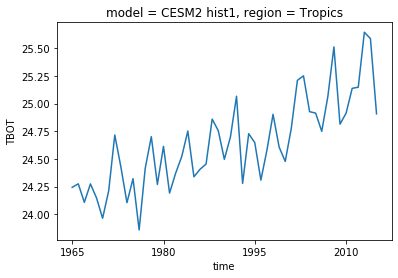

In [9]:
global_ann.TBOT[0,1,:].plot();

In [10]:
print(var)
print(ds.land_area.sum().values*1e-12) #m2 --> million km2
print(ds1.land_area.sum().values*1e-12) #m2 --> million km2

['GPP', 'AR', 'HR', 'NEE', 'NBP', 'TBOT', 'SOILLIQ', 'TOT_SOILLIQ']
126.130505908224
122.344970387456


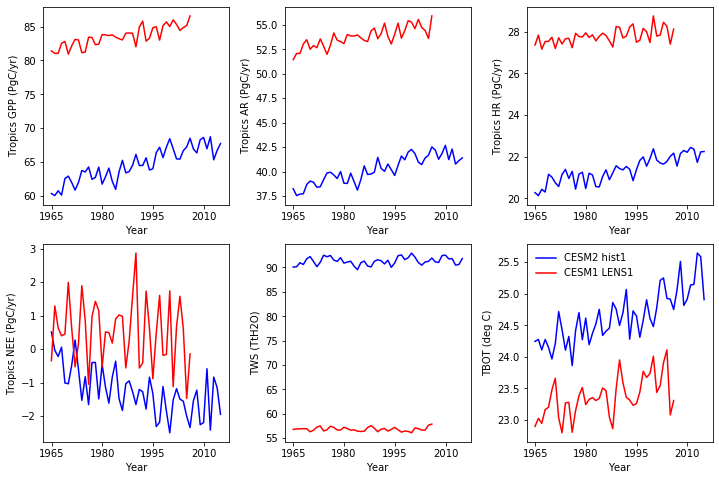

In [11]:
# sanity check
plt.figure(figsize=[12,8])
col = ['b','r']
r = 1
for j in range(4):
    plt.subplot(2,3,(j+1))
    for i in range(2):
        plt.plot(global_ann.time,global_ann[var[j]][i,r,:],color=col[i])
    plt.xlabel('Year')
    plt.ylabel(regions[r]+' '+var[j]+' (PgC/yr)')

plt.subplot(235)
for i in range(2):
    plt.plot(global_ann.time,global_ann.TOT_SOILLIQ[i,r,:],color=col[i])
plt.xlabel('Year')
plt.ylabel('TWS (TtH2O)')

plt.subplot(236)
for i in range(2):
    plt.plot(global_ann.time,global_ann.TBOT[i,r,:],color=col[i])
plt.xlabel('Year')
plt.ylabel('TBOT (deg C)')
plt.legend((Model, Model1),loc=2,frameon=False)
plt.subplots_adjust(wspace=0.3);

## Detrend data and fit linear model

In [12]:
global_ann_dt = xr.Dataset(coords={'model': [Model,Model1], 'region': regions, 'time': temp.time})
v2 = ['GPP','AR','HR','NEE','NBP','TOT_SOILLIQ', 'TBOT']
for i in range(len(v2)):
    global_ann_dt[v2[i]] = xr.DataArray(np.empty(out_shape), dims=('model','region','time')) * np.nan
    for j in range(len(regions)):
        global_ann_dt[v2[i]][0,j,:] = signal.detrend(global_ann[v2[i]][0,j,:])
        global_ann_dt[v2[i]][1,j,0:len(years1)] = signal.detrend(global_ann[v2[i]][1,j,0:len(years1)])

In [13]:
print(global_ann_dt['time.year'].isel(time=slice(16,None)))
global_sd = global_ann_dt.isel(time=slice(16,None)).std('time') 
print(global_sd)

<xarray.DataArray 'year' (time: 35)>
array([1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990,
       1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001,
       2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012,
       2013, 2014])
Coordinates:
  * time     (time) object 1980-12-16 12:00:00 ... 2014-12-16 12:00:00
<xarray.Dataset>
Dimensions:      (model: 2, region: 2)
Coordinates:
  * model        (model) object 'CESM2 hist1' 'CESM1 LENS1'
  * region       (region) object 'Global' 'Tropics'
Data variables:
    GPP          (model, region) float64 1.537 1.181 1.141 0.853
    AR           (model, region) float64 0.976 0.723 0.8625 0.6403
    HR           (model, region) float64 0.3814 0.2855 0.383 0.3421
    NEE          (model, region) float64 0.6624 0.5358 0.9814 0.9875
    NBP          (model, region) float64 0.6623 0.5655 0.9818 0.9879
    TOT_SOILLIQ  (model, region) float64 0.9169 0.7548 0.6731 0.4413
    TBOT         (model, region) flo

## Plot
Loop through C fluxes w/ moisture and temperature anomalies


/glade/u/home/wwieder/miniconda3/envs/python-tutorial/lib/python3.7/site-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # Remove the CWD from sys.path while we load stuff.
/glade/u/home/wwieder/miniconda3/envs/python-tutorial/lib/python3.7/site-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # Remove the CWD from sys.path while we load stuff.
/glade/u/home/wwiede

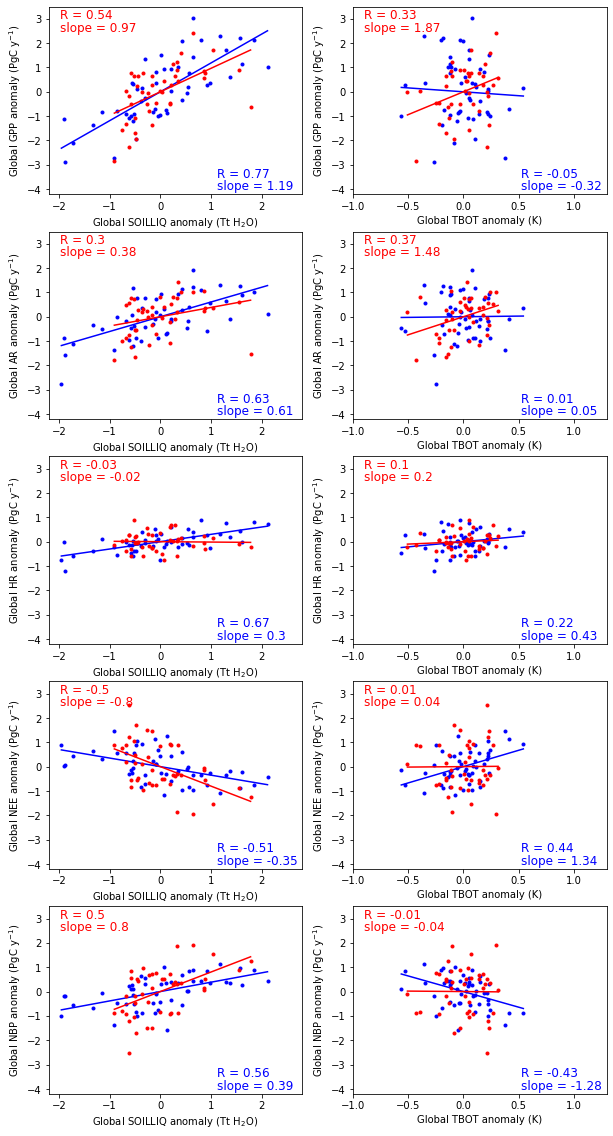

In [14]:
nyrs = [len(years),len(years1)]
r = 0          #region 0 = global, 1 = tropics

fig = plt.figure(figsize=[10,20])
k = 0
for j in range(5):
    for h in range(2):
        k = k+1
        for i in range(2):
            plt.subplot(5,2,k)
            if h == 0:
                x  = global_ann_dt.TOT_SOILLIQ[i,r,0:nyrs[i]].values
                xlim=[-2.2,2.8]
            else:
                x  = global_ann_dt.TBOT[i,r,0:nyrs[i]].values
                xlim=[-1,1.3]

            y  = global_ann_dt[v2[j]][i,r,0:nyrs[i]].values
            model = LinearRegression().fit(x.reshape((-1, 1)), y)
            R = np.round(stats.pearsonr(x,y)[0],2)
            slope = np.round(model.coef_,2)[0]

            xRange = np.array([x.min(),x.max()]).reshape(-1, 1)
            yPred = model.predict(xRange)

            plt.plot(x, y,'.',color=col[i])
            plt.plot(xRange,yPred, color=col[i])
            plt.ylim(-4.2,3.5)
            plt.xlim(xlim)

            if i == 1:
                #plt.text(xlim[0]*0.9,3,Model1,fontsize=12, color='r')
                plt.text(xlim[0]*0.9,3,'R = '+str(R),fontsize=12, color='r')
                plt.text(xlim[0]*0.9,2.5,'slope = '+str(slope),fontsize=12, color='r')
                #plt.text(-2.,1.5,'1964-2005',fontsize=12, color='r')

            if i == 0: 
                #plt.text(xlim[1]*0.4,-2.5,Model,fontsize=12, color='b')
                plt.text(xlim[1]*0.4,-3.5,'R = '+str(R),fontsize=12, color='b')
                plt.text(xlim[1]*0.4,-4.0,'slope = '+str(slope),fontsize=12, color='b')
                #plt.text(xlim[1]*0.4,-4.0,'1964-2014',fontsize=12, color='b')

        if h == 0: 
            plt.xlabel(regions[r]+' SOILLIQ anomaly (Tt $\mathregular{H_2O}$)')
        else:
            plt.xlabel(regions[r]+' TBOT anomaly (K)')
            
        plt.ylabel(regions[r]+' '+v2[j]+' anomaly (PgC $\mathregular{y^{-1}}$)');
#plt.title(Model);

The slope of the line is similar to gamma_iav from Gretchen's 2018 paper (PgC y^-1 K^-1)?

How similar are global and tropical anomalies?

In [15]:
print(v2)

['GPP', 'AR', 'HR', 'NEE', 'NBP', 'TOT_SOILLIQ', 'TBOT']


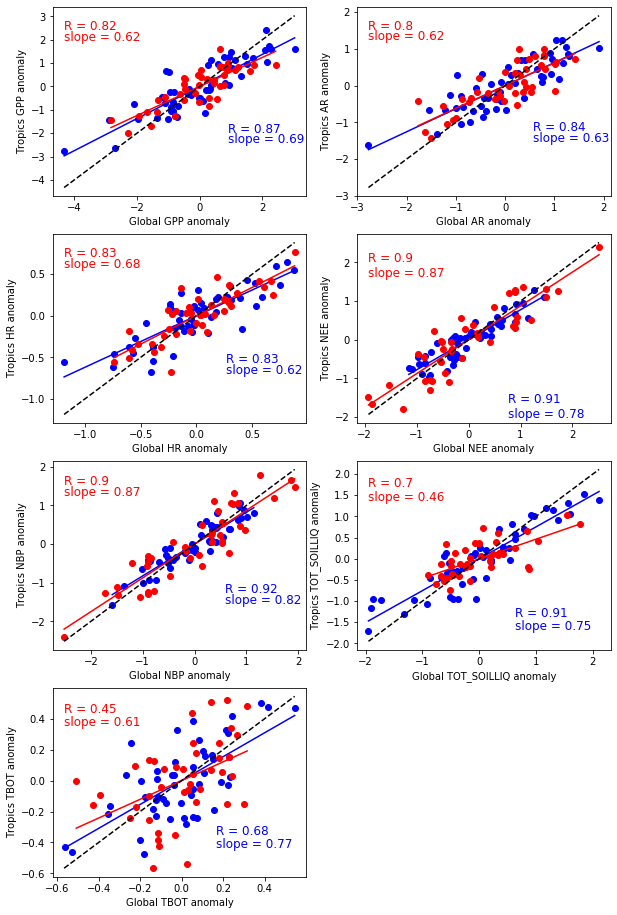

In [16]:
fig = plt.figure(figsize=[10,16])
k = 0

for j in range(len(v2)):
    k = k+1
    plt.subplot(4,2,k)
    x_range = [global_ann_dt[v2[j]].min(),global_ann_dt[v2[j]].max()]
    for i in range(2): #for each model
        y  = global_ann_dt[v2[j]][i,1,0:nyrs[i]].values  # tropics only
        x  = global_ann_dt[v2[j]][i,0,0:nyrs[i]].values  # global
        model = LinearRegression().fit(x.reshape((-1, 1)), y)
        R = np.round(stats.pearsonr(x,y)[0],2)
        slope = np.round(model.coef_,2)[0]

        xlim=[x.min(),x.max()]
        xRange = np.array(xlim).reshape(-1, 1)
        yPred = model.predict(xRange)

        plt.plot(x, y,'o',color=col[i])
        plt.plot(xRange,yPred, color=col[i])
        
        if i == 1:
            plt.text(x_range[0],x_range[1]*0.8,'R = '+str(R),fontsize=12, color='r')
            plt.text(x_range[0],x_range[1]*0.65,'slope = '+str(slope),fontsize=12, color='r')

        if i == 0: 
            plt.text(x_range[1]*0.3,x_range[1]*-0.65,'R = '+str(R),fontsize=12, color='b')
            plt.text(x_range[1]*0.3,x_range[1]*-0.8,'slope = '+str(slope),fontsize=12, color='b')

            
    plt.ylabel(regions[1]+' '+v2[j]+' anomaly')
    plt.xlabel(regions[0]+' '+v2[j]+' anomaly')
        
    plt.plot(x_range, x_range, 'k--')



Slope says what fraction of global anomalies are expliained by tripics?

## TWS & TBOT correlation

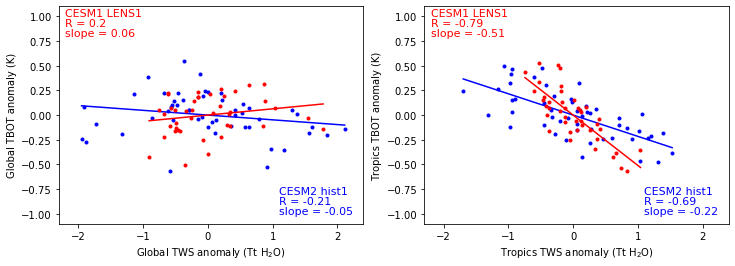

In [21]:
#SOILLIQ ~ TBOT
r = 0
fig = plt.figure(figsize=[12,4])
for r in range(2):
    plt.subplot(1,2,(r+1))
    for i in range(2):
        x  = global_ann_dt.TOT_SOILLIQ[i,r,0:nyrs[i]].values
        y  = global_ann_dt.TBOT[i,r,0:nyrs[i]].values
        model = LinearRegression().fit(x.reshape((-1, 1)), y)
        R = np.round(stats.pearsonr(x,y)[0],2)
        slope = np.round(model.coef_,2)[0]

        xRange = np.array([x.min(),x.max()]).reshape(-1, 1)
        yPred = model.predict(xRange)

        plt.plot(x, y,'.',color=col[i])
        plt.plot(xRange,yPred, color=col[i])

        plt.xlim(-2.3,2.4)
        plt.ylim(-1.1,1.1)
        if i == 1:
            plt.text(-2.2,1.0,Model1,fontsize=11, color='r')
            plt.text(-2.2,0.9,'R = '+str(R),fontsize=11, color='r')
            plt.text(-2.2,0.8,'slope = '+str(slope),fontsize=11, color='r')
            #plt.text(-2.,1.5,'1964-2005',fontsize=12, color='r')

        if i == 0: 
            plt.text(1.1,-0.8,Model,fontsize=11, color='b')
            plt.text(1.1,-0.9,'R = '+str(R),fontsize=11, color='b')
            plt.text(1.1,-1.0,'slope = '+str(slope),fontsize=11, color='b')

    plt.xlabel(regions[r]+' TWS anomaly (Tt $\mathregular{H_2O}$)')
    plt.ylabel(regions[r]+' TBOT anomaly (K)');
    #plt.title(Model);